In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v10_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v10_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [4]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000125c737df1802b6e365f93c96d3c8,7531,0,0,-1,0,0,-1,-1,0,0,97.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,132.0,1158.5,33.0,10.0,10.0,7.0,5,12,15,19,97420,28008,22512,15711,953,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028802,0.028005
1,000125c737df1802b6e365f93c96d3c8,441,0,1,-1,0,0,-1,-1,0,0,314.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,161.0,714.5,16.0,7.0,7.0,4.0,5,12,15,19,97420,28008,22512,15711,958,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.032295,0.031288
2,000125c737df1802b6e365f93c96d3c8,2480,0,2,-1,0,0,-1,-1,0,0,144.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,142.0,961.5,23.0,9.0,9.0,6.0,5,12,15,19,97420,28008,22512,15711,941,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028136,0.027376
3,000125c737df1802b6e365f93c96d3c8,13240,0,3,-1,0,0,-1,-1,0,0,150.0,1.0,1,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,123.0,1340.0,38.0,11.0,11.0,8.0,5,12,15,19,97420,28008,22512,15711,558,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.027888,0.027165
4,000125c737df1802b6e365f93c96d3c8,10378,1,4,-1,0,0,-1,-1,0,0,264.0,1.0,1,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,109.0,1679.5,47.0,15.0,15.0,10.0,5,12,15,19,97420,28008,22512,15711,474,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.035129,0.033974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.016129,0.015955
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.019737,0.019411
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.036554,0.035222,0.025794,0.025178
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013

In [5]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### CatBoost Ranker

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no', 'predict_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# CatBoost のパラメータ
params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 10000,
    'depth': 6,
    'random_seed': 42531,
    "cat_features": cat_cols,
    'task_type': 'GPU',  # GPUを使用するための設定
}

In [7]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(10):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1634527	best: 0.1634527 (0)	total: 128ms	remaining: 21m 24s
1:	test: 0.1745252	best: 0.1745252 (1)	total: 248ms	remaining: 20m 37s
2:	test: 0.1822207	best: 0.1822207 (2)	total: 366ms	remaining: 20m 19s
3:	test: 0.1815544	best: 0.1822207 (2)	total: 488ms	remaining: 20m 18s
4:	test: 0.1847602	best: 0.1847602 (4)	total: 608ms	remaining: 20m 14s
5:	test: 0.1858292	best: 0.1858292 (5)	total: 727ms	remaining: 20m 10s
6:	test: 0.1915028	best: 0.1915028 (6)	total: 844ms	remaining: 20m 5s
7:	test: 0.1955558	best: 0.1955558 (7)	total: 962ms	remaining: 20m 1s
8:	test: 0.1979123	best: 0.1979123 (8)	total: 1.08s	remaining: 20m
9:	test: 0.2024980	best: 0.2024980 (9)	total: 1.2s	remaining: 20m 1s
10:	test: 0.2032954	best: 0.2032954 (10)	total: 1.32s	remaining: 20m 1s
11:	test: 0.2041927	best: 0.2041927 (11)	total: 1.44s	remaining: 19m 59s
12:	test: 0.2050022	best: 0.2050022 (12)	total: 1.56s	remaining: 19m 58s
13:	test: 0.2068037	best: 0.2068037 (13)	total: 1.68s	remaining: 19m 57s
14:	tes

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1695175	best: 0.1695175 (0)	total: 128ms	remaining: 21m 24s
1:	test: 0.1838533	best: 0.1838533 (1)	total: 249ms	remaining: 20m 46s
2:	test: 0.1879606	best: 0.1879606 (2)	total: 370ms	remaining: 20m 31s
3:	test: 0.1947407	best: 0.1947407 (3)	total: 492ms	remaining: 20m 28s
4:	test: 0.1955297	best: 0.1955297 (4)	total: 611ms	remaining: 20m 21s
5:	test: 0.1969845	best: 0.1969845 (5)	total: 731ms	remaining: 20m 16s
6:	test: 0.1968091	best: 0.1969845 (5)	total: 855ms	remaining: 20m 20s
7:	test: 0.1971529	best: 0.1971529 (7)	total: 974ms	remaining: 20m 16s
8:	test: 0.1994706	best: 0.1994706 (8)	total: 1.11s	remaining: 20m 34s
9:	test: 0.1995860	best: 0.1995860 (9)	total: 1.23s	remaining: 20m 31s
10:	test: 0.2051944	best: 0.2051944 (10)	total: 1.35s	remaining: 20m 28s
11:	test: 0.2061625	best: 0.2061625 (11)	total: 1.47s	remaining: 20m 25s
12:	test: 0.2106519	best: 0.2106519 (12)	total: 1.59s	remaining: 20m 22s
13:	test: 0.2116492	best: 0.2116492 (13)	total: 1.71s	remaining: 20m 21

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1621339	best: 0.1621339 (0)	total: 126ms	remaining: 21m 3s
1:	test: 0.1740695	best: 0.1740695 (1)	total: 246ms	remaining: 20m 30s
2:	test: 0.1791674	best: 0.1791674 (2)	total: 367ms	remaining: 20m 21s
3:	test: 0.1836364	best: 0.1836364 (3)	total: 486ms	remaining: 20m 15s
4:	test: 0.1837321	best: 0.1837321 (4)	total: 606ms	remaining: 20m 11s
5:	test: 0.1858555	best: 0.1858555 (5)	total: 726ms	remaining: 20m 9s
6:	test: 0.1901611	best: 0.1901611 (6)	total: 848ms	remaining: 20m 10s
7:	test: 0.1967129	best: 0.1967129 (7)	total: 967ms	remaining: 20m 7s
8:	test: 0.1966129	best: 0.1967129 (7)	total: 1.09s	remaining: 20m 6s
9:	test: 0.1972037	best: 0.1972037 (9)	total: 1.21s	remaining: 20m 4s
10:	test: 0.2038278	best: 0.2038278 (10)	total: 1.33s	remaining: 20m 5s
11:	test: 0.2036000	best: 0.2038278 (10)	total: 1.45s	remaining: 20m 7s
12:	test: 0.2062426	best: 0.2062426 (12)	total: 1.57s	remaining: 20m 6s
13:	test: 0.2065438	best: 0.2065438 (13)	total: 1.69s	remaining: 20m 5s
14:	tes

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1681693	best: 0.1681693 (0)	total: 132ms	remaining: 22m
1:	test: 0.1822585	best: 0.1822585 (1)	total: 259ms	remaining: 21m 34s
2:	test: 0.1866963	best: 0.1866963 (2)	total: 382ms	remaining: 21m 12s
3:	test: 0.1916414	best: 0.1916414 (3)	total: 501ms	remaining: 20m 53s
4:	test: 0.1919057	best: 0.1919057 (4)	total: 622ms	remaining: 20m 43s
5:	test: 0.1918066	best: 0.1919057 (4)	total: 742ms	remaining: 20m 35s
6:	test: 0.1919320	best: 0.1919320 (6)	total: 863ms	remaining: 20m 31s
7:	test: 0.1980760	best: 0.1980760 (7)	total: 982ms	remaining: 20m 26s
8:	test: 0.2022534	best: 0.2022534 (8)	total: 1.1s	remaining: 20m 22s
9:	test: 0.2059634	best: 0.2059634 (9)	total: 1.22s	remaining: 20m 18s
10:	test: 0.2059455	best: 0.2059634 (9)	total: 1.34s	remaining: 20m 15s
11:	test: 0.2059361	best: 0.2059634 (9)	total: 1.46s	remaining: 20m 15s
12:	test: 0.2096273	best: 0.2096273 (12)	total: 1.58s	remaining: 20m 15s
13:	test: 0.2107321	best: 0.2107321 (13)	total: 1.7s	remaining: 20m 13s
14:	te

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1653055	best: 0.1653055 (0)	total: 130ms	remaining: 21m 44s
1:	test: 0.1780238	best: 0.1780238 (1)	total: 253ms	remaining: 21m 4s
2:	test: 0.1825364	best: 0.1825364 (2)	total: 372ms	remaining: 20m 38s
3:	test: 0.1838174	best: 0.1838174 (3)	total: 492ms	remaining: 20m 29s
4:	test: 0.1890414	best: 0.1890414 (4)	total: 612ms	remaining: 20m 23s
5:	test: 0.1916987	best: 0.1916987 (5)	total: 733ms	remaining: 20m 20s
6:	test: 0.1953348	best: 0.1953348 (6)	total: 851ms	remaining: 20m 14s
7:	test: 0.1996121	best: 0.1996121 (7)	total: 969ms	remaining: 20m 10s
8:	test: 0.1992056	best: 0.1996121 (7)	total: 1.09s	remaining: 20m 15s
9:	test: 0.1996730	best: 0.1996730 (9)	total: 1.22s	remaining: 20m 15s
10:	test: 0.2060840	best: 0.2060840 (10)	total: 1.34s	remaining: 20m 15s
11:	test: 0.2082953	best: 0.2082953 (11)	total: 1.46s	remaining: 20m 14s
12:	test: 0.2101710	best: 0.2101710 (12)	total: 1.58s	remaining: 20m 12s
13:	test: 0.2115961	best: 0.2115961 (13)	total: 1.7s	remaining: 20m 11s


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1622748	best: 0.1622748 (0)	total: 126ms	remaining: 20m 59s
1:	test: 0.1673356	best: 0.1673356 (1)	total: 247ms	remaining: 20m 35s
2:	test: 0.1713202	best: 0.1713202 (2)	total: 365ms	remaining: 20m 15s
3:	test: 0.1816857	best: 0.1816857 (3)	total: 486ms	remaining: 20m 13s
4:	test: 0.1829015	best: 0.1829015 (4)	total: 606ms	remaining: 20m 10s
5:	test: 0.1868761	best: 0.1868761 (5)	total: 728ms	remaining: 20m 13s
6:	test: 0.1921123	best: 0.1921123 (6)	total: 846ms	remaining: 20m 8s
7:	test: 0.2013628	best: 0.2013628 (7)	total: 966ms	remaining: 20m 7s
8:	test: 0.2054363	best: 0.2054363 (8)	total: 1.09s	remaining: 20m 7s
9:	test: 0.2055169	best: 0.2055169 (9)	total: 1.21s	remaining: 20m 8s
10:	test: 0.2064756	best: 0.2064756 (10)	total: 1.33s	remaining: 20m 7s
11:	test: 0.2067458	best: 0.2067458 (11)	total: 1.45s	remaining: 20m 6s
12:	test: 0.2071276	best: 0.2071276 (12)	total: 1.57s	remaining: 20m 6s
13:	test: 0.2068899	best: 0.2071276 (12)	total: 1.69s	remaining: 20m 8s
14:	te

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1622044	best: 0.1622044 (0)	total: 127ms	remaining: 21m 10s
1:	test: 0.1692939	best: 0.1692939 (1)	total: 250ms	remaining: 20m 48s
2:	test: 0.1844345	best: 0.1844345 (2)	total: 370ms	remaining: 20m 32s
3:	test: 0.1854173	best: 0.1854173 (3)	total: 490ms	remaining: 20m 24s
4:	test: 0.1922035	best: 0.1922035 (4)	total: 609ms	remaining: 20m 16s
5:	test: 0.1930787	best: 0.1930787 (5)	total: 727ms	remaining: 20m 11s
6:	test: 0.1931257	best: 0.1931257 (6)	total: 846ms	remaining: 20m 7s
7:	test: 0.1982908	best: 0.1982908 (7)	total: 964ms	remaining: 20m 4s
8:	test: 0.2003627	best: 0.2003627 (8)	total: 1.08s	remaining: 20m 3s
9:	test: 0.2005191	best: 0.2005191 (9)	total: 1.2s	remaining: 20m 1s
10:	test: 0.2007452	best: 0.2007452 (10)	total: 1.32s	remaining: 20m
11:	test: 0.2021403	best: 0.2021403 (11)	total: 1.44s	remaining: 19m 59s
12:	test: 0.2058933	best: 0.2058933 (12)	total: 1.56s	remaining: 19m 58s
13:	test: 0.2092694	best: 0.2092694 (13)	total: 1.68s	remaining: 19m 57s
14:	tes

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1673722	best: 0.1673722 (0)	total: 129ms	remaining: 21m 33s
1:	test: 0.1725214	best: 0.1725214 (1)	total: 255ms	remaining: 21m 15s
2:	test: 0.1756437	best: 0.1756437 (2)	total: 376ms	remaining: 20m 53s
3:	test: 0.1804469	best: 0.1804469 (3)	total: 498ms	remaining: 20m 44s
4:	test: 0.1817336	best: 0.1817336 (4)	total: 616ms	remaining: 20m 31s
5:	test: 0.1868445	best: 0.1868445 (5)	total: 736ms	remaining: 20m 26s
6:	test: 0.1928276	best: 0.1928276 (6)	total: 858ms	remaining: 20m 24s
7:	test: 0.1937962	best: 0.1937962 (7)	total: 978ms	remaining: 20m 21s
8:	test: 0.1991479	best: 0.1991479 (8)	total: 1.1s	remaining: 20m 20s
9:	test: 0.1991861	best: 0.1991861 (9)	total: 1.22s	remaining: 20m 20s
10:	test: 0.1995361	best: 0.1995361 (10)	total: 1.34s	remaining: 20m 20s
11:	test: 0.2002690	best: 0.2002690 (11)	total: 1.47s	remaining: 20m 19s
12:	test: 0.2038218	best: 0.2038218 (12)	total: 1.59s	remaining: 20m 20s
13:	test: 0.2046133	best: 0.2046133 (13)	total: 1.71s	remaining: 20m 20s

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1621351	best: 0.1621351 (0)	total: 130ms	remaining: 21m 39s
1:	test: 0.1724506	best: 0.1724506 (1)	total: 251ms	remaining: 20m 56s
2:	test: 0.1803753	best: 0.1803753 (2)	total: 370ms	remaining: 20m 33s
3:	test: 0.1857763	best: 0.1857763 (3)	total: 490ms	remaining: 20m 23s
4:	test: 0.1925606	best: 0.1925606 (4)	total: 610ms	remaining: 20m 19s
5:	test: 0.1939452	best: 0.1939452 (5)	total: 731ms	remaining: 20m 16s
6:	test: 0.1988401	best: 0.1988401 (6)	total: 856ms	remaining: 20m 21s
7:	test: 0.2010246	best: 0.2010246 (7)	total: 977ms	remaining: 20m 20s
8:	test: 0.2013746	best: 0.2013746 (8)	total: 1.1s	remaining: 20m 17s
9:	test: 0.2040368	best: 0.2040368 (9)	total: 1.22s	remaining: 20m 15s
10:	test: 0.2040788	best: 0.2040788 (10)	total: 1.33s	remaining: 20m 11s
11:	test: 0.2049213	best: 0.2049213 (11)	total: 1.45s	remaining: 20m 9s
12:	test: 0.2082967	best: 0.2082967 (12)	total: 1.57s	remaining: 20m 9s
13:	test: 0.2100900	best: 0.2100900 (13)	total: 1.7s	remaining: 20m 9s
14:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1794754	best: 0.1794754 (0)	total: 129ms	remaining: 21m 27s
1:	test: 0.1832671	best: 0.1832671 (1)	total: 251ms	remaining: 20m 54s
2:	test: 0.1956714	best: 0.1956714 (2)	total: 372ms	remaining: 20m 38s
3:	test: 0.1987689	best: 0.1987689 (3)	total: 492ms	remaining: 20m 28s
4:	test: 0.2018388	best: 0.2018388 (4)	total: 612ms	remaining: 20m 22s
5:	test: 0.2041152	best: 0.2041152 (5)	total: 733ms	remaining: 20m 21s
6:	test: 0.2052260	best: 0.2052260 (6)	total: 855ms	remaining: 20m 20s
7:	test: 0.2056030	best: 0.2056030 (7)	total: 976ms	remaining: 20m 18s
8:	test: 0.2077650	best: 0.2077650 (8)	total: 1.1s	remaining: 20m 19s
9:	test: 0.2099060	best: 0.2099060 (9)	total: 1.22s	remaining: 20m 18s
10:	test: 0.2105142	best: 0.2105142 (10)	total: 1.34s	remaining: 20m 16s
11:	test: 0.2110027	best: 0.2110027 (11)	total: 1.46s	remaining: 20m 15s
12:	test: 0.2110241	best: 0.2110241 (12)	total: 1.58s	remaining: 20m 14s
13:	test: 0.2129612	best: 0.2129612 (13)	total: 1.7s	remaining: 20m 13s


              Feature Id  Importances
0          count_yado_no     0.022735
1        TE_yado_no_mean     0.017429
2            wid_cd_rank     0.014290
3           count_ken_cd     0.014198
4                yado_no     0.014144
5             max_seq_no     0.006813
6         TE_yado_no_var     0.001205
7              onsen_flg     0.000158
8            kd_stn_5min     0.000109
9            ken_cd_rank     0.000079
10        TE_ken_cd_mean     0.000057
11        TE_wid_cd_mean     0.000052
12      wireless_lan_flg     0.000048
13         TE_ken_cd_var     0.000029
14         TE_wid_cd_var     0.000017
15           kd_bch_5min     0.000016
16     kd_conv_walk_5min     0.000015
17          count_wid_cd     0.000011
18           kd_slp_5min     0.000009
19              yad_type     0.000004
20          label_sml_cd     0.000003
21          label_lrg_cd     0.000002
22                seq_no     0.000000
23           diff_seq_no     0.000000
24                is_odd     0.000000
25  multiple

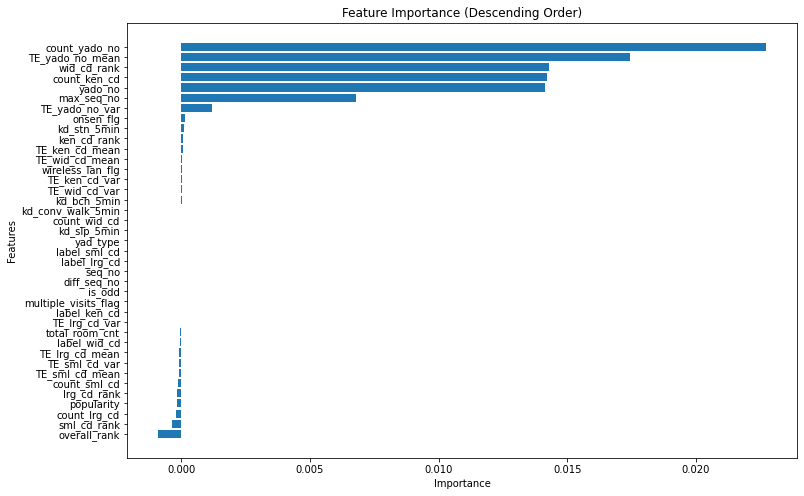

In [8]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()



In [9]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [10]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.102340
1,000125c737df1802b6e365f93c96d3c8,441,-0.056744
2,000125c737df1802b6e365f93c96d3c8,2480,0.190732
3,000125c737df1802b6e365f93c96d3c8,13240,0.038003
4,000125c737df1802b6e365f93c96d3c8,10378,0.095290


In [11]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.102340
1,000125c737df1802b6e365f93c96d3c8,441,-0.056744
2,000125c737df1802b6e365f93c96d3c8,2480,0.190732
3,000125c737df1802b6e365f93c96d3c8,13240,0.038003
4,000125c737df1802b6e365f93c96d3c8,10378,0.095290
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-3.012812
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-1.747743
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.284710
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.647378


In [12]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.102340
1,000125c737df1802b6e365f93c96d3c8,441,-0.056744
2,000125c737df1802b6e365f93c96d3c8,2480,0.190732
3,000125c737df1802b6e365f93c96d3c8,13240,0.038003
4,000125c737df1802b6e365f93c96d3c8,10378,0.095290
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-3.012812
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-1.747743
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.284710
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.647378


In [13]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver9_oof_pred.csv', index=False)

In [14]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.102340
1,000125c737df1802b6e365f93c96d3c8,441,-0.056744
2,000125c737df1802b6e365f93c96d3c8,2480,0.190732
3,000125c737df1802b6e365f93c96d3c8,13240,0.038003
4,000125c737df1802b6e365f93c96d3c8,10378,0.095290
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-3.012812
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-1.747743
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.284710
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.647378


### CVの計算

In [15]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [16]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [17]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[902, 3894, 12491, 7749, 1284, 11380, 4072, 5490, 254]
CPU times: user 150 ms, sys: 3.8 ms, total: 154 ms
Wall time: 153 ms


In [18]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:42<00:00, 6751.20it/s]


In [19]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209
1,2570,8225,8253,11104,4488,1586,8747,3725,2259,3564
2,4863,1967,5238,13642,9039,6722,2957,4355,11724,7509
3,626,755,109,13296,13549,11715,7812,1341,2272,7872
4,96,902,3894,12491,7749,1284,11380,4072,5490,254
...,...,...,...,...,...,...,...,...,...,...
288693,5719,13210,13079,3725,1586,10522,13717,10955,8677,2876
288694,513,2900,4767,8465,963,6654,5299,399,8703,3940
288695,3566,7820,2087,10364,9558,12240,4398,844,4040,7308
288696,10619,12500,7551,570,3238,11091,12781,12829,10616,11316


### 要素の集合にバグがないかを確認

In [20]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [21]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [22]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [24]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
288681


In [25]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [26]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209
1,2570,8225,8253,11104,4488,1586,8747,3725,2259,3564
2,4863,1967,5238,13642,9039,6722,2957,4355,11724,7509
3,626,755,109,13296,13549,11715,7812,1341,2272,7872
4,96,902,3894,12491,7749,1284,11380,4072,5490,254
5,4823,12544,10510,9207,5369,9199,9201,9202,9200,1
6,10442,4574,2480,12774,7531,10378,13240,441,7273,2282
7,10362,10544,12464,111,12125,4744,12962,7681,9508,1755
8,12432,3644,3802,13220,2164,1227,899,4014,9723,13702
9,10478,550,379,6592,3483,9430,4303,3278,9773,2806


In [27]:
train_label.head(20)

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
5,00011afe25c343301ee961b3b0ce2e4d,4823
6,000125c737df1802b6e365f93c96d3c8,10378
7,0001763050a10b21062a1304fb743fd4,10362
8,000178c4d4d567d4715331dd0cdab76c,1227
9,0001e6a407a85dc50ac132a5c7016bab,175


In [28]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [29]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [30]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.4748923945569748


In [31]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [32]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [33]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209,False
1,2570,8225,8253,11104,4488,1586,8747,3725,2259,3564,False
2,4863,1967,5238,13642,9039,6722,2957,4355,11724,7509,False
3,626,755,109,13296,13549,11715,7812,1341,2272,7872,False
4,96,902,3894,12491,7749,1284,11380,4072,5490,254,False


### 推論用の候補テーブルを作成する

In [34]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [35]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[-0.04940543 -0.98716537  0.34844072 ... -0.04987343 -0.05602702
  0.02404901]
1683604


In [36]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(10, 1683604)


In [37]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [38]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,-0.049405
1,00001149e9c73985425197104712478c,4714,-0.987165
2,00001149e9c73985425197104712478c,2680,0.348441
3,00001149e9c73985425197104712478c,4420,-0.649932
4,00001149e9c73985425197104712478c,5466,-0.170728


In [39]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,-0.049405
1,00001149e9c73985425197104712478c,4714,-0.987165
2,00001149e9c73985425197104712478c,2680,0.348441
3,00001149e9c73985425197104712478c,4420,-0.649932
4,00001149e9c73985425197104712478c,5466,-0.170728
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.004679
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.112496
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.049873
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.056027


In [41]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,-0.049405
1,00001149e9c73985425197104712478c,4714,-0.987165
2,00001149e9c73985425197104712478c,2680,0.348441
3,00001149e9c73985425197104712478c,4420,-0.649932
4,00001149e9c73985425197104712478c,5466,-0.170728
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.004679
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.112496
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.049873
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.056027


In [42]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,-0.049405
1,00001149e9c73985425197104712478c,4714,-0.987165
2,00001149e9c73985425197104712478c,2680,0.348441
3,00001149e9c73985425197104712478c,4420,-0.649932
4,00001149e9c73985425197104712478c,5466,-0.170728
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.004679
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.112496
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.049873
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.056027


In [43]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver9_test_pred.csv', index=False)

In [44]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [45]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[11723, 1891, 3781, 12767, 12620, 5623, 11994, 867, 634, 10729]
CPU times: user 89.5 ms, sys: 7.92 ms, total: 97.4 ms
Wall time: 97.3 ms


In [46]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:26<00:00, 6713.08it/s]


In [47]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,9830,2680,11561,5466,9534,4420,4714,6563,5785
1,7014,613,8108,143,11923,6555,12862,4066,6129,11237
2,757,9190,9910,410,6730,1774,13570,6721,10485,7710
3,12341,3359,6991,10861,6489,10746,5080,4180,13521,1542
4,10826,9020,9623,3476,2862,3854,3844,5372,12029,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,7062,2278,3440,5744,10042,10997,9743
174696,1227,4014,13702,3802,12432,899,13220,2164,9723,3644
174697,2087,7308,11037,13719,13797,11796,12939,8143,13241,5810
174698,2692,2373,3100,10287,3002,5513,13672,1687,4976,12281


In [48]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [49]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [50]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [51]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [52]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [53]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,9830,2680,11561,5466,9534,4420,4714,6563,5785,False
1,7014,613,8108,143,11923,6555,12862,4066,6129,11237,False
2,757,9190,9910,410,6730,1774,13570,6721,10485,7710,False
3,12341,3359,6991,10861,6489,10746,5080,4180,13521,1542,False
4,10826,9020,9623,3476,2862,3854,3844,5372,12029,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,7062,2278,3440,5744,10042,10997,9743,False
174696,1227,4014,13702,3802,12432,899,13220,2164,9723,3644,False
174697,2087,7308,11037,13719,13797,11796,12939,8143,13241,5810,False
174698,2692,2373,3100,10287,3002,5513,13672,1687,4976,12281,False


In [55]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver9.csv', index=False)